<a href="https://colab.research.google.com/github/adnan119/Pytorch-Projects/blob/main/InceptionNet/InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing original InceptionNet Model**

###**Key Highlights from the Model:**


*   Because of the huge variation in the location of the information i.e. the variations in the main object to be classified present, choosing the right kernel size for the convolution operation becomes tough. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally.
*   **Solution:** Why not have filters with multiple sizes operate on the same level? The network essentially would get a bit “wider” rather than “deeper”.
* Deep neural networks are computationally expensive. To make it cheaper, the authors limit the number of input channels by adding an extra 1x1 convolution before the 3x3 and 5x5 convolutions. Though adding an extra operation may seem counterintuitive, 1x1 convolutions are far more cheaper than 5x5 convolutions, and the reduced number of input channels also help.
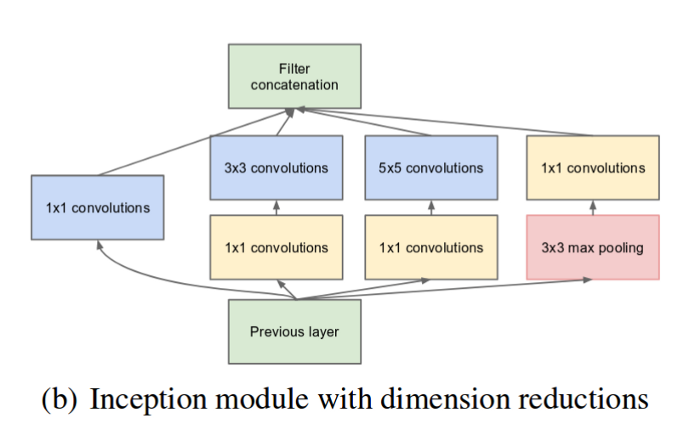
* Needless to say, it is a pretty deep classifier. As with any very deep network, it is subject to the vanishing gradient problem.
To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers (The purple boxes in the image). They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. Weight value used in the paper was 0.3 for each auxiliary loss.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/PyTorch_Projects/animal_dataset/

/content/drive/MyDrive/PyTorch_Projects/animal_dataset


##**Spatially separable convolutions**
Convolutions that can be separated across their spatial axes.
One of the most famous convolutions that can be separated spatially is the Sobel kernel, used to detect edges.
**[Spatially seperable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)**

In [4]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=ee704014a2f8926230b9118cca0456efc5913254637ee921b4bd16c28b65b233
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [5]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, ConcatDataset , DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler

import os
import cv2
import numpy as np
import imutils

from google.colab.patches import cv2_imshow

from torchviz import make_dot

In [6]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    x = self.conv(x)
    x = self.batchnorm(x)
    x = self.relu(x)
    return x

In [7]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [8]:
class inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_max_1x1):
    super(inception_block, self).__init__()


    self.branch_1 = conv_block(in_channels, out_1x1, kernel_size=1)


    self.branch_2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
    )


    self.branch_3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size = 1),
        conv_block(red_5x5, out_5x5, kernel_size=5, padding=2)
    )


    self.branch_4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride = 1, padding=1),
        conv_block(in_channels, out_max_1x1, kernel_size=1)
    )

  def forward(self, x):
    return torch.cat([self.branch_1(x), self.branch_2(x), self.branch_3(x), self.branch_4(x)], 1)

In [9]:
class InceptionNet(nn.Module):
  def __init__(self, aux_logits=True, in_channels=3, num_classes=1000):
    super(InceptionNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride = 2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

    self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)


    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None


  def forward(self, x):

    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    # x = self.conv3(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)

    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
        return aux1, aux2, x
    else:
        return x

In [10]:
x = torch.randn(3, 3, 224, 224)
model = InceptionNet(num_classes=1000)
y = model(x)
print(y[2].shape)

torch.Size([3, 1000])


In [11]:
make_dot(y, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [13]:
m = cv2.imread("rnn_torchviz.png")
print(m.shape)

(6640, 6061, 3)


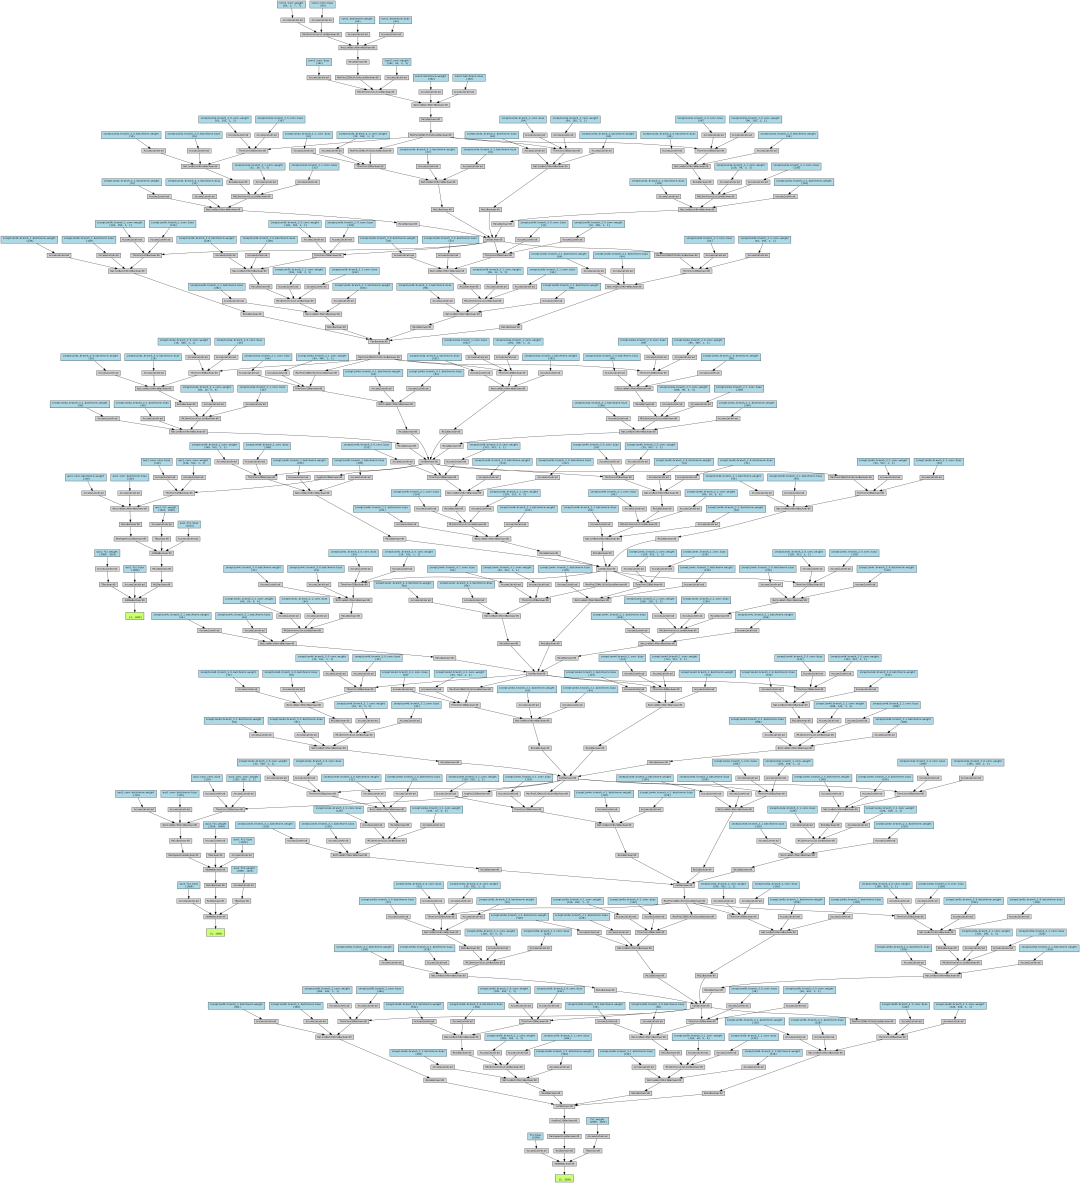

In [14]:
ms = imutils.resize(m , width=1080)
cv2_imshow(ms)

# **1. Loading the Dataset**

In [15]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('./raw-img/'):
    for filename in filenames:
        path, folder = os.path.split(dirname)

### **Defining transforms**

In [16]:
train_on_gpu = torch.cuda.is_available()
train_transform = transforms.Compose([transforms.RandomRotation(25),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255), 
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

### **Instantiating dataset & train/test/val split**

In [17]:
class AnimalDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)


dataset = datasets.ImageFolder(path)
# test_dataset = datasets.ImageFolder(path, transform=test_transform)

train_data = AnimalDataset(dataset,train_transform)
val_data = AnimalDataset(dataset,test_transform)
test_data = AnimalDataset(dataset,test_transform)

train_size = 0.8
num_train = len(dataset)
indices = list(range(num_train))
train_split = int(np.floor(train_size * num_train))
test_split = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:train_split], indices[train_split:test_split], indices[test_split:]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
print(len(train_sampler))
print(len(valid_sampler))
print(len(test_sampler))

20945
2618
2619


### **Data Loaders**

In [18]:

trainLoader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler = train_sampler)

valLoader = torch.utils.data.DataLoader(val_data, batch_size=8, sampler = valid_sampler)

testLoader = torch.utils.data.DataLoader(test_data, batch_size=8, sampler = test_sampler)

### **Training configurations**

In [19]:
if train_on_gpu:
  model.cuda()

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=0.01)

lrsheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=0.000001)

### **Training loop**

In [ ]:
epochs = 25
print_every = 40
steps = 0
valid_loss_min = np.Inf
total = 0
correct = 0

model.to('cuda')
validation_loss = 0
for e in range(epochs):
    print(e)
    training_loss = 0
    lrsheduler.step(validation_loss)
    model.train()
    for ii, (inputs, labels) in enumerate(trainLoader):
        print(ii)
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        aux_output_1, aux_output_2, outputs = model.forward(inputs)

        loss_1 = criterion(aux_output_1, labels)
        loss_2 = criterion(aux_output_2, labels)
        loss_output = criterion(outputs, labels)

        loss = 0.3 * loss_1 + 0.4 * loss_2 + loss_output

        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*inputs.size(0)
        
        
    model.eval()
    for ii, (inputs, labels) in enumerate(valLoader):

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    training_loss = training_loss/len(trainLoader.dataset)
    validation_loss = validation_loss/len(valLoader.dataset)
    _correct = (correct*100)/total
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        e, training_loss, validation_loss, _correct))
    
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))

        model.class_to_idx = train_data.class_to_idx
        checkpoint = model.state_dict()
        
        torch.save(checkpoint, 'InceptionNet.pt')
        valid_loss_min = validation_loss

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
